# Simple Wall Loss Fit

In this section, we integrate particle simulations with data import tools to optimize wall-loss parameters in a chamber environment. This process is essential in understanding and accurately modeling the behavior of aerosol particles within a confined space.

### Approach:

- We commence by defining the initial size distribution of particles at the start time (`t_start`).
- Utilizing `particula.Solver`, we simulate the dynamics of particles in the chamber up to a specified end time (`t_end`).
- An optimization routine is then employed, which iteratively adjusts the wall eddy diffusivity parameter. The objective is to align the simulated particle size distribution as closely as possible with the observed (measured) distribution.

**Note**: This method, while conceptually straightforward, may not be the most computationally efficient. However, it provides clear insights into the fitting process of wall-loss parameters in aerosol simulations.

In [11]:
# Forward Wall Loss Simulation

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from datetime import datetime

from particula.data import loader_interface, settings_generator
from particula.data.tests.example_data.get_example_data import get_data_folder

from particula.data import stream_stats
from particula.util import convert, time_manage

from particula.dynamics import Solver
from particula import particle

from particula.util.convert import distribution_convert_pdf_pms

## Data Preparation: SMPS Data

In this section, we focus on preparing the data necessary for our particle simulation and optimization process. This involves setting the data directory, loading the data, and performing initial conversions.

**Steps:**

- Set Data Directory: We define the path to our data directory. This directory contains all the necessary data files for the simulation.
- Load 1D Data: We load the 1-dimensional (1D) data, which represents specific characteristics of particles measured by the Scanning Mobility Particle Sizer (SMPS).
- Load 2D Data: Similar to step 2, we load the 2-dimensional (2D) data. This data provides a more comprehensive representation of particle characteristics.
- Data Conversion: The loaded 2D data is initially in the form of dn/dlogDp. We convert this to a suitable format for further analysis.

In [12]:
# Set the parent directory of the data folders
path = get_data_folder()
print('Path to data folder:')
print(path.rsplit('particula')[-1])

# Load the 2D data
smps_2d_stream_settings = settings_generator.load_settings_for_stream(
    path=path,
    subfolder='chamber_data',
    settings_suffix='_smps_2d',
)
stream_smps_2d = loader_interface.load_files_interface(
    path=path,
    settings=smps_2d_stream_settings
)

# Convert from dn/dlogDp
stream_smps_2d.data = convert.convert_sizer_dn(
    diameter=np.array(stream_smps_2d.header, dtype=float),
    dn_dlogdp=stream_smps_2d.data,
)

Path to data folder:
\data\tests\example_data
  Loading file: 2023-09-25_160155_SMPS.csv


## Data Preparation: Time Window Selection and Data Cleaning

In this section, we focus on refining our dataset by selecting specific time windows and cleaning the data. This step is crucial to ensure the accuracy and relevance of our particle simulation and optimization.

**Steps**:

- Select Time Window: We define a specific time window that is considered 'bad' or irrelevant for our analysis. This window is defined by a start and an end epoch time.
- Remove Bad Data: Data within this 'bad' time window is removed from our dataset to improve the quality of our analysis.
- Crop Data Start and End: We further refine our dataset by cropping the data at the start and end of our experiment. This is done by defining start and end epoch times for the experiment and removing data outside this range.
- Data Averaging: Finally, we average the data into 15-minute intervals. This step simplifies the dataset and makes it more manageable for analysis.
python

In [13]:
# Select the time window
bad_window_start_epoch = time_manage.time_str_to_epoch(
    time='09-25-2023 19:00:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)
bad_window_end_epoch = time_manage.time_str_to_epoch(
    time='09-25-2023 19:45:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)

print(f"Length of stream before crop: {len(stream_smps_2d)}")
# Remove the bad data
stream_smps_2d = stream_stats.remove_time_window(
    stream=stream_smps_2d,
    epoch_start=bad_window_start_epoch,
    epoch_end=bad_window_end_epoch,
)

# Crop start
experiment_start_epoch = time_manage.time_str_to_epoch(
    time='09-25-2023 15:25:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)
stream_smps_2d = stream_stats.remove_time_window(
    stream=stream_smps_2d,
    epoch_start=stream_smps_2d.time[0],
    epoch_end=experiment_start_epoch,
)

# Crop the end
experiment_end_epoch = time_manage.time_str_to_epoch(
    time='09-26-2023 07:00:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)
stream_smps_2d = stream_stats.remove_time_window(
    stream=stream_smps_2d,
    epoch_start=experiment_end_epoch,
    epoch_end=stream_smps_2d.time[-1],
)

# Average to 15 minute intervals
average_interval = 60 * 15  # seconds
stream_averaged_2d = stream_stats.average_std(
    stream=stream_smps_2d,
    average_interval=average_interval,
)

# get the time in hours
experiment_time = time_manage.relative_time(
    epoch_array=stream_averaged_2d.time.copy(),
    units='hours',
)

Length of stream before crop: 336


## Visualization of Processed Data

After refining our dataset, the next step is to visualize the data. This allows us to observe trends and patterns in the particle concentration over time, which is crucial for understanding the behavior of aerosols in the chamber. We expect to see decrease particle concentrations.

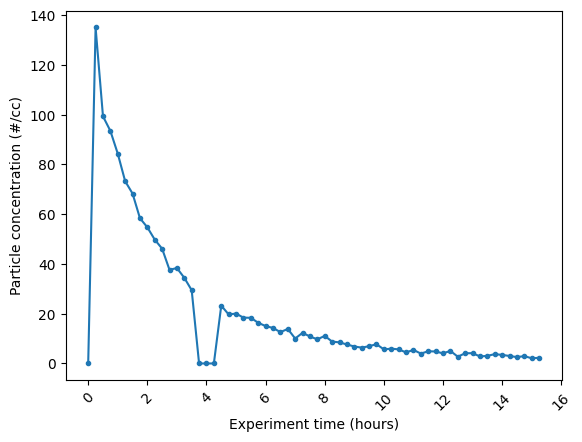

In [14]:
# plot the 1d data
fig, ax = plt.subplots()
ax.plot(
    experiment_time,
    stream_averaged_2d.data[:, 100],
    label='Concentration',
    marker='.',
)
plt.xticks(rotation=45)
ax.set_xlabel("Experiment time (hours)")
ax.set_ylabel('Particle concentration (#/cc)')
plt.show()

## Setting Simulation Properties: Chamber Flow Rates and Dilution Correction

In this section, we define and apply key simulation properties related to the chamber flow rates and dilution correction. This is an important step to ensure that the simulation accurately represents the physical conditions of the experiment.

**Steps**:

- Define Chamber Flow Rates: We set the flow rates for both pushing air into the chamber and dilution.
- Dilution Correction: A dilution correction factor is calculated to account for the combined effect of push and dilution flow rates.
- Concentration Scaling: The particle concentration data is scaled to account for the dilution correction. This step adjusts the concentration values to reflect the true particle concentration inside the chamber.
- Radius and Volume Adjustments: The particle size data (originally in diameter) is converted to radius and adjusted to meters. The concentration data is also converted to number per cubic meter.
- Rate Constants: We calculate the rate constants for the chamber in terms of minutes and hours. These constants are crucial for understanding the dynamics of particle behavior within the chamber.

In [15]:
# Chamber flow rates
chamber_push = 1.27  # L/min
chamber_dillution = 1.27  # L/min

# Dilution correction
dilution_correction = (chamber_push + chamber_dillution) / chamber_push
# Scale the concentrations for dilution
stream_smps_2d.data *= dilution_correction

# Convert diameter to radius in meters and adjust concentration units
radius_bins = stream_smps_2d.header_float / 2 * 1e-9  # convert to m and radius
stream_smps_2d.data *= 1e6  # convert to number per m3

# Chamber volume and rate constants
CHAMBER_VOLUME = 908.2  # L
k_rate_chamber_min = chamber_push / CHAMBER_VOLUME
k_rate_chamber_hr = k_rate_chamber_min * 60

## Defining Simulation Functions

To simulate and optimize the chamber conditions for aerosol particles, we define several key functions. Each function plays a specific role in simulating the chamber environment, calculating error metrics, and optimizing parameters.

### Functions:

1. **simulate_chamber_interval**:
   - **Purpose**: Simulates aerosol particle dynamics in a chamber over a specified time interval, considering various processes like coagulation, condensation, and wall loss.
   - **Inputs**: Particle properties, time array, concentration, and radius bins.
   - **Outputs**: Particle number density distribution and concentration distribution over time.

2. **simulation_error**:
   - **Purpose**: Calculates the Mean Absolute Error (MAE) between the simulated and observed particle distributions.
   - **Inputs**: Simulated and observed particle distributions.
   - **Outputs**: MAE value, quantifying the accuracy of the simulation.

3. **chamber_ktp_objective_funciton**:
   - **Purpose**: Serves as an objective function for optimization, comparing the simulation output to fit chamber ktp values.
   - **Inputs**: Chamber ktp value, particle properties, time array, concentration, and radius bins.
   - **Outputs**: Error metric from the simulation error function.

4. **optimize_ktp_value**:
   - **Purpose**: Optimizes the chamber ktp value to minimize the error between the simulated and observed particle distributions.
   - **Inputs**: Initial guesses, bounds, and particle properties.
   - **Outputs**: Optimized ktp value.


In [16]:
def simulate_chamber_interval(
    particle_kwargs: dict,
    time_array: np.ndarray,
    concentration_m3: np.ndarray,
    radius_bins: np.ndarray,
):
    """
    Simulate the aerosol chamber for a given time interval.

    This function simulates the dynamics of aerosol particles in a chamber
    over a specified time interval. It considers processes like
    coagulation, condensation, nucleation, dilution, and wall loss.

    Args:
    -----
        particle_kwargs (dict): Keyword arguments for the Particle object,
            including particle properties and chamber characteristics.
        time_array (np.ndarray): Array of time points over which to
            simulate the chamber dynamics.
        concentration_m3 (np.ndarray): Concentration of particles per
            cubic meter for each radius bin.
        radius_bins (np.ndarray): Array of radius bins for the particles.

    Returns:
    --------
        tuple: A tuple containing two elements:
            - simulation_pdf (np.ndarray): The particle number density
                distribution over time as a probability density function.
            - concentration_pdf (np.ndarray): The concentration distribution
                over time as a probability density function.

    Note:
        - The function modifies 'particle_kwargs' to include
            particle number and radius.
        - It assumes that the time array is increasing sequence of time points.
    """

    # Convert size distribution to PDF
    concentration_pdf = distribution_convert_pdf_pms(
        x_array=radius_bins,
        distribution=concentration_m3,
        to_pdf=True
    ) * radius_bins

    # Set number and radius in particle_kwargs
    particle_kwargs["particle_number"] = concentration_pdf[0, :]
    particle_kwargs["particle_radius"] = radius_bins
    particle_kwargs["volume"] = 1  # volume of concentration in cubic meters

    # Rebase time to start from zero
    rebased_time = time_array - time_array[0]

    # Create particle distribution
    particle_dist = particle.Particle(**particle_kwargs)

    # Pack the distribution into the solver
    rates_kwargs = {
        "particle": particle_dist,
    }

    # Initialize and solve the dynamics
    solution_coag = Solver(
        time_span=rebased_time,
        do_coagulation=True,
        do_condensation=False,
        do_nucleation=False,
        do_dilution=True,
        do_wall_loss=True,
        **rates_kwargs
    ).solution(method='odeint')

    # Process the solution
    simulation_pdf = solution_coag[:, :] * particle_dist.particle_radius
    concentration_pdf = concentration_pdf * simulation_pdf.u
    return simulation_pdf, concentration_pdf


# calculate the error
def simulation_error(simulation_pdf, concentration_pdf):
    """
    Calculate the Mean Absolute Error (MAE) between simulation PDF and concentration PDF.

    The function computes the MAE as the average of absolute differences between 
    the two provided probability density functions (PDFs). This metric is useful 
    for quantifying the accuracy of a simulation against observed data.

    Args:
        simulation_pdf (np.ndarray): The simulated particle number density distribution as a PDF.
        concentration_pdf (np.ndarray): The observed concentration distribution as a PDF.

    Returns:
        float: The Mean Absolute Error between the two PDFs.
    
    Raises:
        ValueError: If the input arrays do not have the same shape.
    """

    if simulation_pdf.shape != concentration_pdf.shape:
        raise ValueError("The shapes of simulation_pdf and concentration_pdf must be the same.")

    return np.mean(np.abs(simulation_pdf.m - concentration_pdf.m))


def chamber_ktp_objective_funciton(
        chamber_ktp_value: float,
        particle_kwargs: dict,
        time_array: np.ndarray,
        concentration_m3: np.ndarray,
        radius_bins: np.ndarray,
) -> float:
    """objective funciton to compare simualiton of chamber to fit ktp values
    """
    
    particle_kwargs['chamber_ktp_value'] = chamber_ktp_value * u.s**-1

    simulation_pdf, concentration_pdf = simulate_chamber_interval(
        particle_kwargs=particle_kwargs,
        time_array=time_array,
        concentration_m3=concentration_m3,
        radius_bins=radius_bins,
    )

    return simulation_error(simulation_pdf, concentration_pdf)


def optimize_ktp_value(
        particle_kwargs: dict,
        time_array: np.ndarray,
        concentration_m3: np.ndarray,
        radius_bins: np.ndarray,
        guess_ktp_value=1,
        display_fitting=False,
) -> float:
    """ optimized for ktp value"""

    bounds = Bounds(lb=0.01, ub=10)

    problem = {
        'fun': lambda x: chamber_ktp_objective_funciton(
            chamber_ktp_value=x,
            particle_kwargs=particle_kwargs,
            time_array=time_array,
            concentration_m3=concentration_m3,
            radius_bins=radius_bins),
        'x0': guess_ktp_value,
        'bounds': bounds,
        'tol': 1e-4,
        'options': {'disp': display_fitting, 'maxiter' : 10},
    }

    return minimize(**problem)

## Performing Chamber Simulation and Optimization

In this step, we use the previously defined functions to perform the actual simulation and optimization of the chamber environment. The focus here is to fine-tune the parameters for the an accurate representation of aerosol particle behavior in the chamber.

### Setting Input Parameters:

- Define a range of indices to select a subset of data for the simulation.
- Extract the corresponding concentration and time array data from the dataset.
- Set initial particle properties and chamber conditions (like density, charge, dilution rate, and chamber dimensions).

### Optimizing ktp Value:

- Utilize the `optimize_ktp_value` function to find the optimal ktp value that minimizes the error between the simulated and observed particle distributions.
- Display the optimized ktp value.

### Running Final Simulation:

- Update the particle parameters with the optimized ktp value.
- Run the simulate_chamber_interval function with the updated parameters to simulate the chamber environment.
- Retrieve the simulated particle number density distribution and concentration distribution.

In [23]:
# inputs
index_span = [4, 8]
concentration_m3= stream_averaged_2d.data[index_span[0]:index_span[1], :]
time_array_simulation = stream_averaged_2d.time[index_span[0]:index_span[1]]

particle_kwargs = {
    "particle_density": 1.8e3,  # Density of particles in kg/m^3
    "particle_charge": 0,  # Charge of particles in elementary charges
    "dilution_rate_coefficient": k_rate_chamber_hr * u.hour**-1,
    "wall_loss_approximation": "rectangle",  # Method for approximating wall loss
    # Dimensions of the chamber in meters
    "chamber_dimension": [0.739, 0.739, 1.663] * u.m,
    "chamber_ktp_value": 0.5 * u.s**-1,  # Rate of wall eddy diffusivity
}

# Optimization
fit_return = optimize_ktp_value(
    particle_kwargs=particle_kwargs,
    time_array=time_array_simulation,
    concentration_m3=concentration_m3,
    radius_bins=radius_bins,
)

print(f"Fit ktp value: {fit_return.x[0]}")
print(f"Fit error: {fit_return.fun}")

# Final Simulation
particle_kwargs['chamber_ktp_value'] = fit_return.x[0] * u.s**-1
simulation_pdf, concentration_pdf = simulate_chamber_interval(
    particle_kwargs=particle_kwargs,
    time_array=time_array_simulation,
    concentration_m3=concentration_m3,
    radius_bins=radius_bins,
)

Fit ktp value: 0.7688882939107488
Fit error: 92.00172725730974


## Visualization of Simulation Results

In this section, we plot the results of our simulation to visualize how the particle size distribution changes over time in the chamber. This comparison between the initial and final states of both the simulation and experimental data provides valuable insights into the accuracy and dynamics of our model.

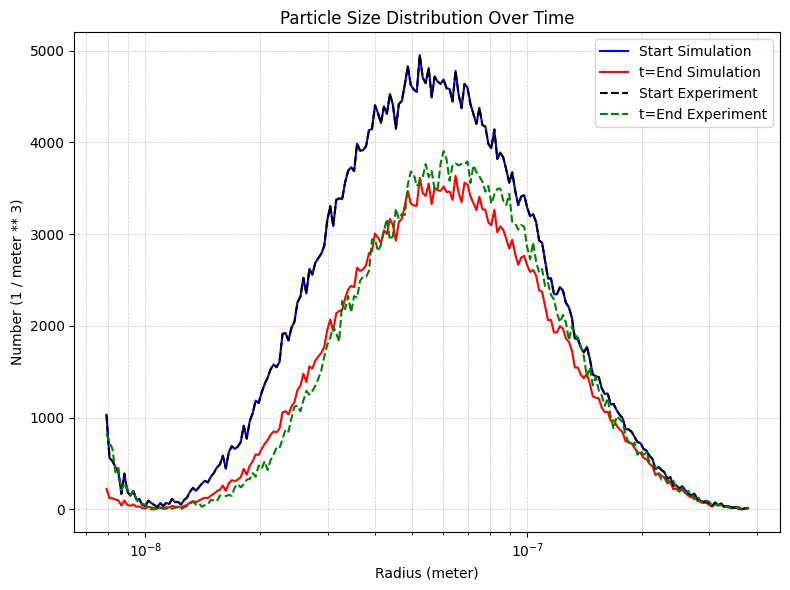

In [24]:
# Plotting the simulation results
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

# Plotting simulation and experimental data
# Initial distribution
ax.semilogx(
    radius_bins,
    (simulation_pdf.m[0, :]),
    '-b',
    label='Start Simulation')
# Final distribution
ax.semilogx(
    radius_bins,
    (simulation_pdf.m[-1, :]),
    '-r',
    label='t=End Simulation')
ax.semilogx(
    radius_bins,
    concentration_pdf[0, :],
    '--k',
    label='Start Experiment')  # Initial measured
ax.semilogx(
    radius_bins,
    concentration_pdf[-1, :],
    '--g',
    label='t=End Experiment')  # Final measured

# Setting labels, title, and grid
ax.set_xlabel("Radius (meter)")
ax.set_ylabel(f"Number ({simulation_pdf.u})")
ax.set_title("Particle Size Distribution Over Time")
ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

# Adjust layout and show plot
fig.tight_layout()
plt.show()

## Summary of the Notebook

This Jupyter Notebook presents first approach to simulating and analyzing the behavior of aerosol particles in a chamber environment.

### Achievements:
- Successfully combined particle simulations with data import tools to optimize the wall-loss parameters in a chamber.
- Refined the dataset for analysis through careful selection and cropping of time windows.
- Utilized simulation functions to accurately represent and optimize the conditions within the aerosol chamber.
- Visualized both processed and simulated data, providing clear insights into the particle behavior and the accuracy of the simulation.

### Next Steps:

As a continuation of this research, the next step is to explore another method for solving the ordinary differential equation (ODE) problem. This will involve differentiating the data and fitting the aerosol rates more directly. This exploration aims to compare the effectiveness and efficiency of different approaches in modeling the dynamics of aerosol particles in a chamber environment.